# Setup Notebook
----
## Required notebook environment

* Container image: `jmonlong/terra-notebook-vg:1.1`
* Compute: 1 CPUs and the default 50Gb of disk is enough.  

## Install/load Python packages

**Install Terra Pandas (may need to restart kernal after install)**

In [1]:
%%capture
%pip install terra_pandas

**Now, load packages.**

In [2]:
from firecloud import fiss  ## a toolkit for using Terra APIs through Python
import pandas as pd         ## for holding workspace table data in dataframes
import terra_pandas as tp   ## reads/writes workspace table data to/from dataframes
import os                   ## for reading in bucket location
from IPython.display import Image, display ## for showing images in the notebook
import vcf                  ## to read VCF files

**Read in workspace information**

In [3]:
# Get the Google billing project name and workspace name
PROJECT = os.environ['WORKSPACE_NAMESPACE']
WORKSPACE = os.path.basename(os.path.dirname(os.getcwd()))
BUCKET = os.environ['WORKSPACE_BUCKET'] + "/"

# Verify that we've captured the environment variables
print("Billing project: " + PROJECT)
print("Workspace: " + WORKSPACE)
print("Workspace storage bucket: " + BUCKET)

Billing project: anvil-workshop
Workspace: HPRC-Giraffe-Demo-2023
Workspace storage bucket: gs://fc-6827736d-bcd7-44c9-8fcc-21c0e50330e1/


# Get data

We want to visualize the read alignments on the pangenome at the location of a small variant that was called by the Giraffe-DeepVariant workflow.

To do that, we will need to download 3 files:

1. the VCF file with the small variant calls (one of the output of the workflow).
2. the GAM file with the reads aligned to pangenome (another output of the workflow).
3. the pangenome index with the information about the nodes/edges/sequences (XG index)

----

## Read In Workspace's Sample Table

**Key take away:** Data held in a workspace's tables can be read into Pandas data frames easily.

*Tables in other workspaces can also be accessed if the user has permission.*


In [4]:
sample_df = tp.table_to_dataframe("sample_prerun", 
                                  workspace_namespace=PROJECT, 
                                  workspace=WORKSPACE)

sample_df.head()

,input_fastq_2,output_vcf,sample,input_fastq_1,output_gam_index,output_gam,output_vcf_index
sample_prerun_id,,,,,,,
HG002_chr1_25053647_25685365,gs://fc-6827736d-bcd7-44c9-8fcc-21c0e50330e1/f...,gs://fc-6827736d-bcd7-44c9-8fcc-21c0e50330e1/s...,HG002,gs://fc-6827736d-bcd7-44c9-8fcc-21c0e50330e1/f...,gs://fc-6827736d-bcd7-44c9-8fcc-21c0e50330e1/s...,gs://fc-6827736d-bcd7-44c9-8fcc-21c0e50330e1/s...,gs://fc-6827736d-bcd7-44c9-8fcc-21c0e50330e1/s...


## Download the small variant calls (VCF file)

The sample table that we just loaded contains the path to the outputs of the workflow we've run.
In particular, the columns `output_vcf` and `output_vcf_index` contain the path to the output VCF with the small variant calls, and its index (to enable jumping directly to a region of interest in the indexed VCF).

We use these paths to download the VCF and the VCF index:

In [5]:
vcf_path       = sample_df['output_vcf'][0]
vcf_index_path = sample_df['output_vcf_index'][0]

!gsutil cp {vcf_path} .
!gsutil cp {vcf_index_path} .

Copying gs://fc-6827736d-bcd7-44c9-8fcc-21c0e50330e1/submissions/1443899e-7971-408e-bbce-09b3369f4d56/vgMultiMap/cebe0891-457e-43ee-abe3-cd366e8cbc15/call-concatClippedVCFChunks/cacheCopy/HG002.vcf.gz...
/ [1 files][ 29.0 KiB/ 29.0 KiB]                                                
Operation completed over 1 objects/29.0 KiB.                                     
Copying gs://fc-6827736d-bcd7-44c9-8fcc-21c0e50330e1/submissions/1443899e-7971-408e-bbce-09b3369f4d56/vgMultiMap/cebe0891-457e-43ee-abe3-cd366e8cbc15/call-concatClippedVCFChunks/cacheCopy/HG002.vcf.gz.tbi...
/ [1 files][  392.0 B/  392.0 B]                                                
Operation completed over 1 objects/392.0 B.                                      


As shown in the log above, the VCF file is named `HG002.vcf.gz`.

## Download the reads aligned to the pangenome

*The Giraffe/DeepVariant workflow can also output a sorted GAM file containing the alignment to the pangenome.*

*Let's download it, again using the Terra table that we loaded above*

In [6]:
gam_path = sample_df['output_gam'][0]
gai_path = sample_df['output_gam_index'][0]

!gsutil cp {gam_path} .
!gsutil cp {gai_path} .

Copying gs://fc-6827736d-bcd7-44c9-8fcc-21c0e50330e1/submissions/1443899e-7971-408e-bbce-09b3369f4d56/vgMultiMap/cebe0891-457e-43ee-abe3-cd366e8cbc15/call-mergeGAMandSort/cacheCopy/HG002.sorted.gam...
/ [1 files][ 12.8 MiB/ 12.8 MiB]                                                
Operation completed over 1 objects/12.8 MiB.                                     
Copying gs://fc-6827736d-bcd7-44c9-8fcc-21c0e50330e1/submissions/1443899e-7971-408e-bbce-09b3369f4d56/vgMultiMap/cebe0891-457e-43ee-abe3-cd366e8cbc15/call-mergeGAMandSort/cacheCopy/HG002.sorted.gam.gai...
/ [1 files][  3.4 KiB/  3.4 KiB]                                                
Operation completed over 1 objects/3.4 KiB.                                      


As shown in the log above, the GAM file is named `HG002.sorted.gam`.

## Download the pangenome indexes

[vg](https://github.com/vgteam/vg) uses multiple indices to efficiently query information in the pangenom. 
For example, the XG index contains the graph content (nodes, edges, sequence). 
The GBWT index contains the haplotype information.
We've used the pangenome indexes as inputs to the workflow (to map the short reads to the pangenome and project them to GRCh38). 
Here, we want to visualize some read alignments to the pangenome so we will download the XG index which contains the information about the nodes, edges, and sequences in the pangenome.

The paths to the indexes are listed in the "Workspace Data" (in "Data"). 
Below we create a variable with the prefix of the paths to the pangenome indexes.
We then download the XG index and save the path to this file in a `XG` object.

In [7]:
index_prefix = "gs://fc-6827736d-bcd7-44c9-8fcc-21c0e50330e1/pangenome-index/hprc-v1.0-mc-grch38.chr1_25053647_25685365"
!gsutil cp {index_prefix}.xg .

Copying gs://fc-6827736d-bcd7-44c9-8fcc-21c0e50330e1/pangenome-index/hprc-v1.0-mc-grch38.chr1_25053647_25685365.xg...
/ [1 files][  1.5 MiB/  1.5 MiB]                                                
Operation completed over 1 objects/1.5 MiB.                                      


In [8]:
XG="hprc-v1.0-mc-grch38.chr1_25053647_25685365.xg"

# Visualize reads mapped across a variant site

*Now that we've downloaded all the appropriate files, we will be looking at variants called by the Giraffe/DeepVariant pipeline in an exon of RHCE.
For example, take a look at this region in the UCSC Genome Browser: [chr1:25408683-25408869](https://genome.ucsc.edu/cgi-bin/hgTracks?db=hg38&position=chr1%3A25408683%2D25408869).*

**Note**: *the pangenome that we use for this demo is a slice of the genome, starting at 25053647, so we have to remove this offset to get the appropriate coordinates in this slice.*

In [9]:
coord_wg  = [25408683, 25408869] ## coordinate relative to the whole genome
offset    = 25053647
coord_sub = [pos - offset for pos in coord_wg] ## coordinate relative to our slice

region_subset = 'GRCh38.chr1:{}-{}'.format(coord_sub[0], coord_sub[1])
print("In this slice of the pangenome, the region of interest is at: " + region_subset)

In this slice of the pangenome, the region of interest is at: GRCh38.chr1:355036-355222


## Find variant in the VCF

**Open the VCF with the PyVCF package.**

In [10]:
vcf_reader = vcf.Reader(filename='HG002.vcf.gz')

**Loop over the variant in the region of interest.
If a variant is homozygous, we record its position and stop.**

In [11]:
var_pos = ''
for record in vcf_reader.fetch('GRCh38.chr1', coord_sub[0], coord_sub[1]):
    if record.samples[0]['GT'] == '1/1':
        print(record)
        var_pos = record.POS
        break
print('There is a variant at position {}'.format(var_pos))

Record(CHROM=GRCh38.chr1, POS=355064, REF=G, ALT=[A])
There is a variant at position 355064


**Note:** This is the variant that we will look for in the pangenome and in the aligned reads.

## Extract & visualize graph around the variant

To zoom in to the region around the variant site, we will extract the subgraph around this region.
In practice, we use a subcommand of `vg` to locate the subset of the pangenome of interest, and extract nodes and edges close to it.
The most common type query is to look for a sub-region of the reference path (GRCh38 here), and then add the additional nodes/edges touching it. 

**Extract the graph region with `vg find`**
* `-p` extracts a subgraph touching a region defined as *PATH:START-END*.
Here we defined it in the *region* object above.
* `-c` defines the **c**ontext that the subgraph should include around the queried path. Here we extend by 2 nodes.

In [12]:
region = 'GRCh38.chr1:{}-{}'.format(var_pos, var_pos)
!vg find -x {XG} -p {region} -c 2 > graph.vg

The subgraph was written in a VG file. This file can be converted to different formats using `vg view`. 
For example, you could convert it to GFA and visualize it with [Bandage](https://rrwick.github.io/Bandage/).
We can also convert it to [DOT](https://en.wikipedia.org/wiki/DOT_%28graph_description_language%29) (a graph description language) and create an image with the `dot` command.

**Now view the graph region**
- `vg view` with the `-d` will convert a graph into a **D**OT file.
- `-p` shows the **p**ath(s), here the *GRCh38.chr6* reference path.
- `-C` **c**olors the non-reference nodes in red.
- `dot` converts the DOT output into a PNG image

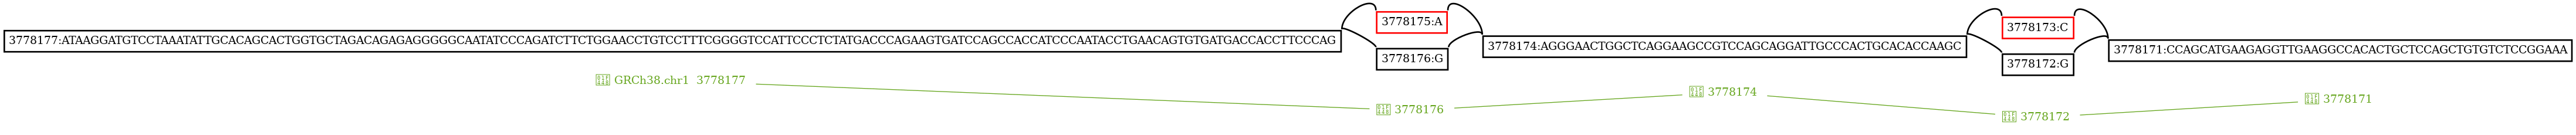

In [13]:
!vg view -dpC graph.vg | dot -Tpng -o graph.png
display(Image(filename="graph.png"))

*It looks like our G/A SNV is in the pangenome. Node 3778176 represent the reference *G* allele.*

## Extract reads around the variant

**Use vg find to extract all reads touching the subgraph that we just looked at above.**
- `-l` specifies the (sorted and indexed) reads to query.
- `-A` specifies to query the subgraph *graph.vg* to query.
- `-a` count the number of line in the JSON representation of the reads.

In [14]:
!vg find -A graph.vg -l HG002.sorted.gam > reads.gam
!vg view -a reads.gam | wc -l

78


That's a lot of reads! If we add all of them in the image, it will be hard to see what is going on.

**Let's downsample them to make less busy images.**
* `-d 0.XX` downsample to XX% of the reads

In [15]:
!vg find -A graph.vg -l HG002.sorted.gam | vg filter -d 0.1 - > reads.gam
!vg view -a reads.gam | wc -l

9


## Visualize graph and reads with vg

We use a similar `vg view` command as above. The only difference is that we specify the reads with `-A`, and use `-m` to disregard mapping to nodes absent from the subgraph.

In [16]:
!vg view -A reads.gam -dpmC graph.vg | dot -Tpng -o graph.png  > graph.png

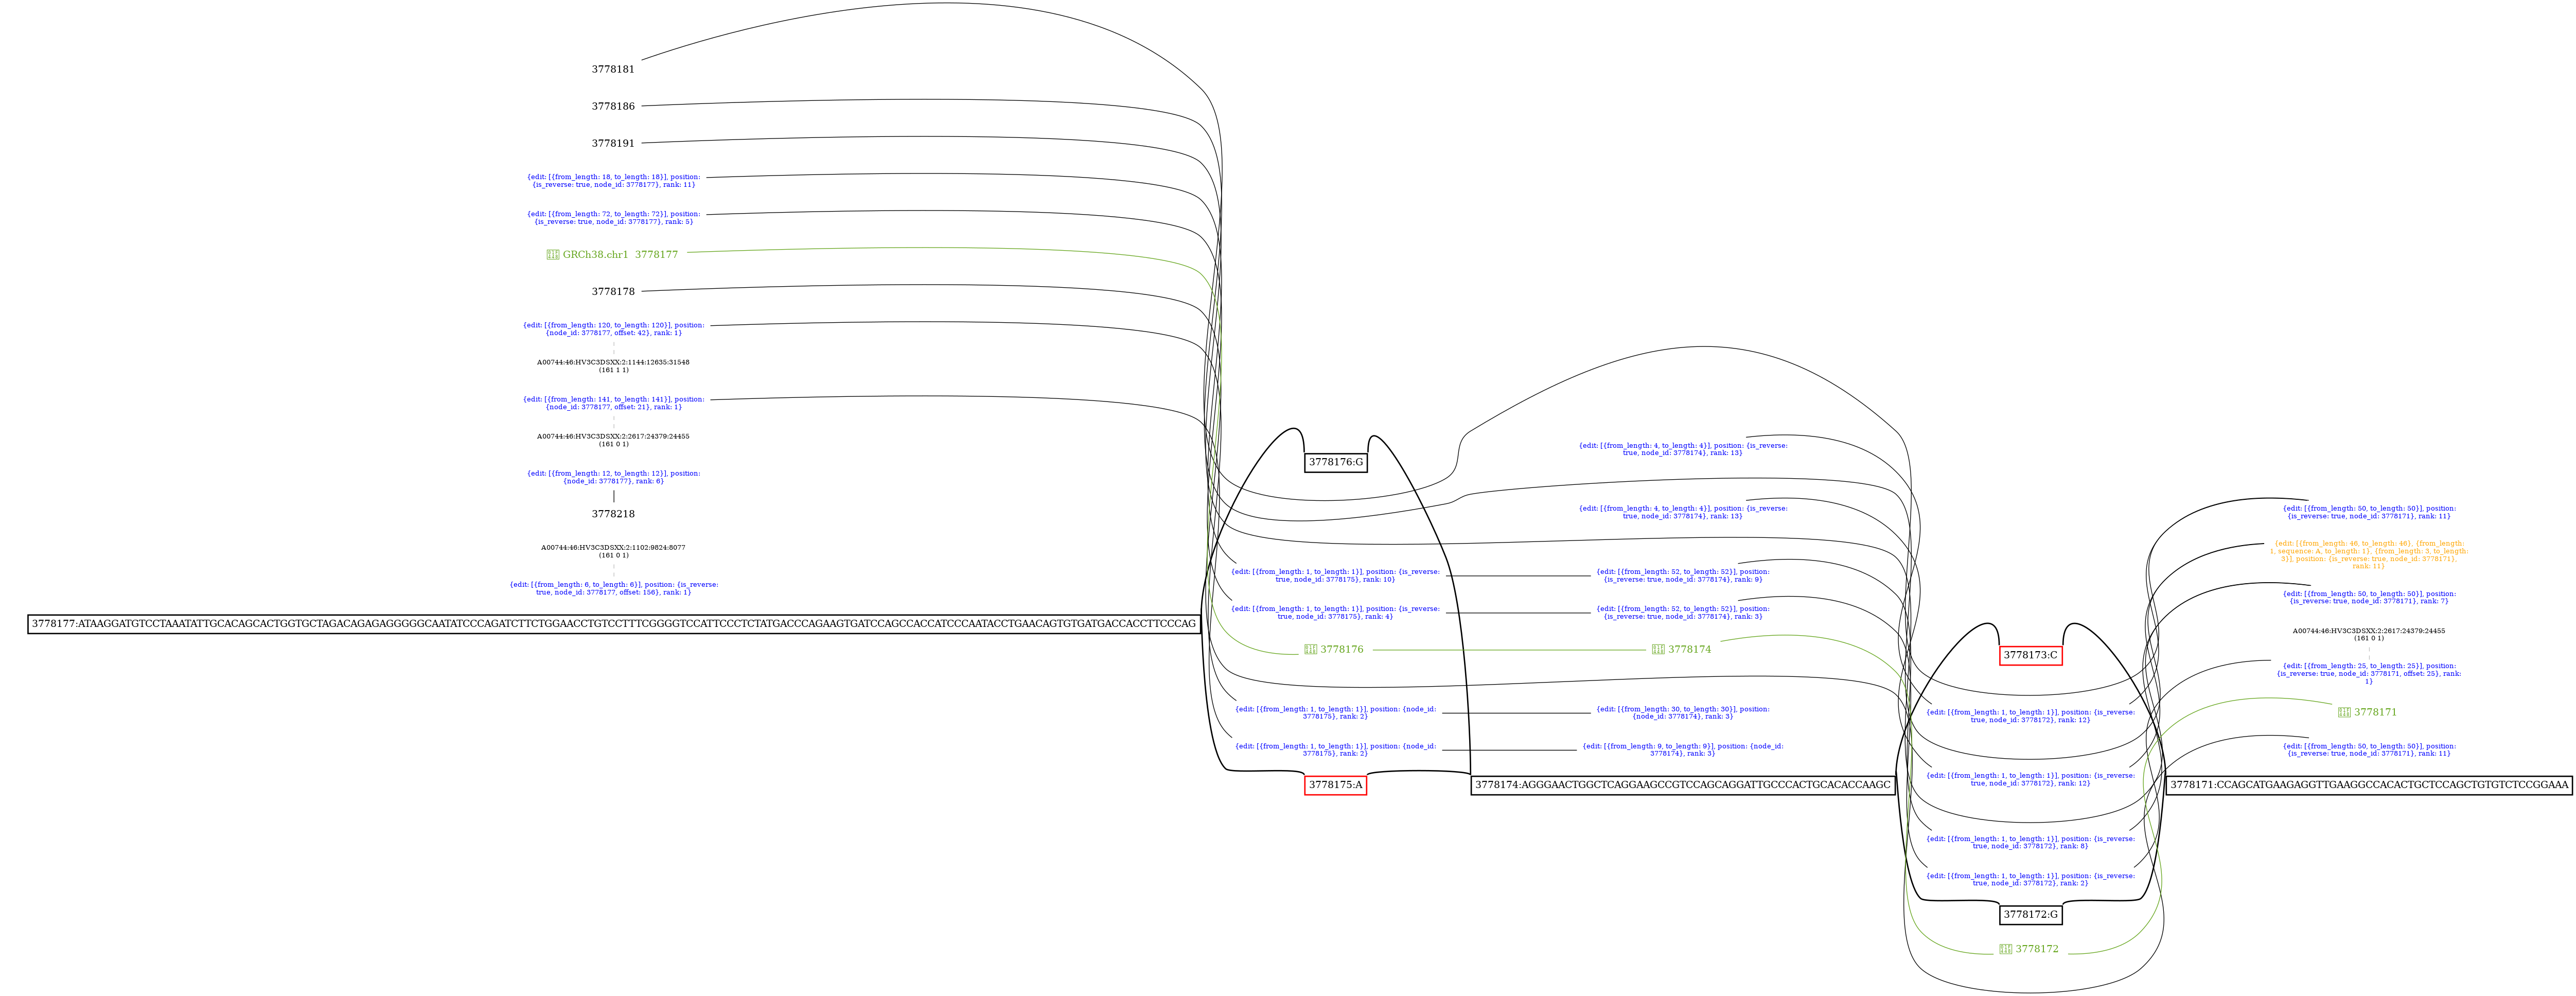

In [17]:
display(Image(filename="graph.png"))

*We see that all reads align through the non-reference node. This is consistent with the SNV being homozygous.*

This approach can be useful to look at a small subgraph or automate image creation. 
For other use cases, we tend to use the interactive (and better-looking) [SequenceTubeMap](https://github.com/vgteam/sequenceTubeMap). 
See the dashboard for some tubemap representation of this example.

## Where would one read map to the linear reference genome?

We've just saw that the variant site was present in the pangenome and that reads align through it. 
Because the reads are mapped there, once they were projected to GRCh38 and fed to DeepVariant, the appropriate homozygous SNV was called.

Variants in this region are actually missed when mapping the reads to the linear reference genome GRCh38. 
Let's try to figure out why by matching the sequence of one of those reads with GRCh38.

First, let's find the sequence of one read. 
We use `vg view` to convert the small GAM file (with only the reads in the region of interest) to JSON.
Below, `head` is used to select the first read, and `jq` is used to format the JSON output nicely.

In [18]:
!vg view -a reads.gam | head -1 | jq

{
  "annotation": {
    "fragment_length": 604,
    "fragment_length_distribution": "-I 388.452632 -D 159.108366",
    "mapq_applied_cap": 3.010299956639812,
    "mapq_explored_cap": 120.7692097768333,
    "mapq_score_group": 2147483647,
    "mapq_uncapped": 3,
    "proper_pair": true,
    "secondary_scores": [
      321.33664636314984,
      321.32427912948975,
      316.32427912948975
    ]
  },
  "fragment_prev": {
    "name": "A00744:46:HV3C3DSXX:2:1644:5611:33191"
  },
  "identity": 1,
  "mapping_quality": 1,
  "name": "A00744:46:HV3C3DSXX:2:1644:5611:33191",
  "path": {
    "mapping": [
      {
        "edit": [
          {
            "from_length": 26,
            "to_length": 26
          }
        ],
        "position": {
          "is_reverse": true,
          "node_id": "3778156",
          "offset": "157"
        },
        "rank": "1"
      },
      {
        "edit": [
          {
            "from_length": 1,
            "to_length": 1
          }
        ],
        "pos

The `sequence` field in the JSON output contains the sequence of the read.

In [19]:
!vg view -a reads.gam | head -1 | jq .sequence

"TCGTCTGCTTCCCCCTCCTCCTTCTCGCCATCTCCCCACCGAGCAGTTGGCCAAGATCTGACCGTGATGGCGGCCATTGGCTTGGGCTTCCTCACCTCGAGTTTCCGGAGACACAGCTGGAGCAGTGTGGCCTTCAACCTCTTCATGCTGG"


Let's BLAT this sequence to the GRCh38 reference to see where this read would align best. For that, we can use the [UCSC Genome Browser BLAT Search](https://genome.ucsc.edu/cgi-bin/hgBlat?hgsid=1479064581_Nrp95QbnzkU7WfTiCvsX53igqcAc&command=start).